# ANOVOS - Data Report
Following notebook shows the list of "data report" related functions supported under ANOVOS package and how it can be invoked accordingly
- [Report Preprocessing](#Report-Preprocessing)
    - [Chart to Objects](#Chart-to-Objects)
    - [Plot Frequency](#Plot-Frequency)
    - [Plot Outlier](#Plot-Outlier)
    - [Plot EventRate](#Plot-EventRate)
    - [Plot Comparative Drift](#Plot-Comparative-Drift)
- [Report Generation](#Report-Generation)
    - [Generate ANOVOS Report](#Generate-ANOVOS-Report)
    - [Generate Executive Summary Report](#Generate-Executive-Summary-Report)
    - [Generate Wiki Report](#Generate-Wiki-Report)
    - [Generate Descriptive Statistics Report](#Generate-Descriptive-Statistics-Report)
    - [Generate Quality Check Report](#Generate-Quality-Check-Report)
    - [Generate Attribute Associations Report](#Generate-Attribute-Associations-Report)
    - [Generate Drift and Stability Report](#Generate-Drift-and-Stability-Report)
    - [Generate Time Series Visualization Report](#Generate-Time-Series-Visualization-Report)

In [1]:
import plotly
from plotly.io import write_json
import plotly.express as px
import plotly.graph_objects as go
from plotly.figure_factory import create_distplot

global_theme = px.colors.sequential.Plasma
global_theme_r = px.colors.sequential.Plasma_r
global_plot_bg_color = 'rgba(0,0,0,0)'
global_paper_bg_color = 'rgba(0,0,0,0)'

**Setting Spark Session**

In [2]:
#set run type variable
run_type = "local" # "local", "emr", "databricks", "ak8s"

In [4]:
#For run_type Azure Kubernetes, run the following block 
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

if run_type == "ak8s":
    fs_path="<insert conf spark.hadoop.fs master url here> ex: spark.hadoop.fs.azure.sas.<container>.<account_name>.blob.core.windows.net"
    auth_key="<insert value of sas_token here>"
    master_url="<insert kubernetes master url path here> ex: k8s://"
    docker_image="<insert name docker image here>"
    kubernetes_namespace ="<insert kubernetes namespace here>"

    # Create Spark config for our Kubernetes based cluster manager
    sparkConf = SparkConf()
    sparkConf.setMaster(master_url)
    sparkConf.setAppName("Anovos_pipeline")
    sparkConf.set("spark.submit.deployMode","client")
    sparkConf.set("spark.kubernetes.container.image", docker_image)
    sparkConf.set("spark.kubernetes.namespace", kubernetes_namespace)
    sparkConf.set("spark.executor.instances", "4")
    sparkConf.set("spark.executor.cores", "4")
    sparkConf.set("spark.executor.memory", "16g")
    sparkConf.set("spark.kubernetes.pyspark.pythonVersion", "3")
    sparkConf.set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
    sparkConf.set(fs_path,auth_key)
    sparkConf.set("spark.kubernetes.authenticate.serviceAccountName", "spark")
    sparkConf.set("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.2.0,com.microsoft.azure:azure-storage:8.6.3,io.github.histogrammar:histogrammar_2.12:1.0.20,io.github.histogrammar:histogrammar-sparksql_2.12:1.0.20,org.apache.spark:spark-avro_2.12:3.2.1")

    # Initialize our Spark cluster, this will actually
    # generate the worker nodes.
    spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
    sc = spark.sparkContext

#For other run types import from anovos.shared.
else:
    from anovos.shared.spark import *
    auth_key = "NA"

In [5]:
sc.setLogLevel("ERROR")
import warnings
warnings.filterwarnings('ignore')

**Input/Output Paths and Parameters**

In [6]:
# For Report Preprocessing
inputPath = "../data/income_dataset/csv"
master_path="../output/income_dataset/data_report/report_stats/"
driftSourcePath = '../data/income_dataset/source'
stabilityPath = '../data/income_dataset/stability_index/'
stabilityOutputPath="../output/income_dataset/data_drift/"
source_path="NA"

# For Report Generation
dataDict_path= '../data/income_dataset/data_dictionary.csv'
metricDict_path= None #'../data/income_dataset/metric_dictionary.csv'
final_report_path = '../output/income_dataset/data_report/'
run_type = 'local'
id_col= 'ifa'
label_col= 'income'
corr_threshold= 0.4
iv_threshold= 0.02
drift_threshold_model= 0.1
max_records=100000
top_geo_records=100
max_cluster=20
eps="0.3,0.5,0.05"
min_samples="500,1100,100"
global_map_box_val=0

**Read Input Data** 

In [7]:
from anovos.data_ingest.data_ingest import read_dataset

In [8]:
#Read input dataset
df=read_dataset(spark, inputPath,'csv',file_configs={"header":"True","delimiter":",","inferSchema":"True"}).drop('capital-gain','capital-loss')
#Read source dataset
source_df = read_dataset(spark, driftSourcePath,"csv",{'header':True,'inferSchema':True}).drop('capital-gain', 'capital-loss')
#Read stability index datasets
df1 = read_dataset(spark, stabilityPath+"0","csv",{'header':True,'inferSchema':True})
df2 = read_dataset(spark, stabilityPath+"1","csv",{'header':True,'inferSchema':True})
df3 = read_dataset(spark, stabilityPath+"2","csv",{'header':True,'inferSchema':True})
df4 = read_dataset(spark, stabilityPath+"3","csv",{'header':True,'inferSchema':True})
df5 = read_dataset(spark, stabilityPath+"4","csv",{'header':True,'inferSchema':True})

In [9]:
df.toPandas().head(5)

ifa   age         workclass    fnlwgt    logfnl empty  education  \
0  1a   NaN         State-gov   77516.0  4.889391  None  Bachelors   
1  2a   NaN  Self-emp-not-inc   83311.0  4.920702  None  Bachelors   
2  3a  38.0           Private  215646.0  5.333741  None    HS-grad   
3  4a  53.0           Private  234721.0  5.370552  None       11th   
4  5a   NaN           Private  338409.0  5.529442  None  Bachelors   

   education-num      marital-status         occupation  ...   race     sex  \
0           13.0       Never-married       Adm-clerical  ...  White    Male   
1           13.0  Married-civ-spouse    Exec-managerial  ...  White    Male   
2            9.0            Divorced  Handlers-cleaners  ...  White    Male   
3            7.0  Married-civ-spouse  Handlers-cleaners  ...  Black    Male   
4           13.0  Married-civ-spouse     Prof-specialty  ...  Black  Female   

  hours-per-week  native-country income          dt_1           dt_2  \
0           40.0    UnitedStates  <=50K   1/8/16 5:59   1/16/16 5:59   
1           13.0    UnitedStates  <=50K  1/8/16 21:09  1/12/16 21:09   
2           40.0    UnitedStates  <=50K   3/8/16 2:21   3/20/16 2:21   
3           40.0    UnitedStates  <=50K   3/8/16 6:31   3/14/16 6:31   
4           40.0            Cuba  <=50K   3/8/16 9:45   3/10/16 9:45   

    latitude   longitude   geohash  
0 -38.624096  177.982468  rb68np99  
1 -40.880497  174.992142  rckjypw0  
2 -37.735630  176.164047  rckm712q  
3 -39.536491  176.832321  rckndgte  
4 -41.128094  175.033722  rckq4596  

[5 rows x 21 columns]

**Generate Required Stats Dataframes and Save as CSV files**

In [10]:
from anovos.data_analyzer.association_evaluator import IG_calculation, IV_calculation
from anovos.data_analyzer.stats_generator import global_summary, measures_of_counts, nonzeroCount_computation, measures_of_dispersion
from anovos.data_analyzer.quality_checker import duplicate_detection, nullRows_detection
from anovos.drift_stability.drift_detector import statistics
from anovos.drift_stability.stability import stability_index_computation
from anovos.data_ingest.ts_auto_detection import ts_preprocess
from anovos.data_analyzer.ts_analyzer import ts_analyzer
from anovos.data_analyzer.geospatial_analyzer import geospatial_autodetection

In [11]:
# Generate stats dataframes
df = ts_preprocess(spark, df, id_col='ifa', output_path=master_path, tz_offset='local')
ts_analyzer(spark, df, id_col='ifa', max_days=3600, output_path=master_path, output_type='daily', tz_offset='local')
odf1 = IV_calculation(spark, idf=df, label_col='income', event_label=">50K")
odf2 = global_summary(spark, idf = df, list_of_cols='all', drop_cols=['ifa'])
odf3 = measures_of_counts(spark, idf = df, list_of_cols='all', drop_cols=['ifa'])
odf4 = measures_of_dispersion(spark, idf = df, list_of_cols='all', drop_cols=['ifa'])
odf5, odf_stats5 = duplicate_detection(spark, idf = df, list_of_cols='all', drop_cols=['ifa'], print_impact=True)
odf6, odf_stats6 = nullRows_detection(spark, idf = df, list_of_cols='all', drop_cols=['ifa'], 
                                      treatment_threshold=0.4, print_impact=True)
odf7 = IG_calculation(spark, idf=df, label_col='income', event_label=">50K")
odf8 = statistics(spark, df, source_df, list_of_cols='all',drop_cols='ifa|income' ,
                  method_type="all", bin_size=10,pre_existing_source=False, source_path="NA")
odf9 = stability_index_computation(spark, [df1,df2,df3,df4,df5],
                                   appended_metric_path=stabilityOutputPath+'historical_metric_1',threshold=2)

lat_cols, long_cols, gh_cols = geospatial_autodetection(df, id_col, master_path, max_records, top_geo_records, max_cluster, eps,
                                                        min_samples, global_map_box_val, run_type, auth_key,
                                                       )

No. of Rows: 32561
No. of UNIQUE Rows: 32561
No. of Duplicate Rows: 0
Percentage of Duplicate Rows: 0.0


+---------------+---------+-------+-------+
|null_cols_count|row_count|row_pct|flagged|
+---------------+---------+-------+-------+
|              1|    11649| 0.3578|      0|
|              2|    20003| 0.6143|      0|
|              3|      871| 0.0267|      0|
|              4|       20| 6.0E-4|      0|
|              5|       11| 3.0E-4|      0|
|              6|        4| 1.0E-4|      0|
|              9|        3| 1.0E-4|      1|
+---------------+---------+-------+-------+



2022-12-01 02:24:30.662 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


In [12]:
from anovos.data_report.report_preprocessing import save_stats

In [13]:
# Save generated stats dataframes into csv
save_stats(spark, odf1, master_path, 'IV_calculation', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf2, master_path, 'global_summary', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf3, master_path, 'measures_of_counts', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf4, master_path, 'measures_of_dispersion', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf_stats5, master_path, 'duplicate_detection', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf_stats6, master_path, 'nullRows_detection', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf7, master_path, 'IG_calculation', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf8, master_path, 'drift_statistics', reread=False, run_type=run_type, auth_key=auth_key)
save_stats(spark, odf9, master_path, 'stabilityIndex_computation', reread=False, run_type=run_type, auth_key=auth_key)

# Report Preprocessing

## Chart to Objects
- API specification of function **charts_to_objects** can be found <a href="https://docs.anovos.ai/api/data_report/report_preprocessing.html">here</a>
- Function charts_to_objects calls all the other plot-generating functions (more examples below) in report_preprocessing module and save the objects.
- Please run the command calling charts_to_objects below to make sure other cells in this section run smoothly.

In [14]:
from anovos.data_report.report_preprocessing import charts_to_objects

In [15]:
charts_to_objects(spark, df, list_of_cols='all', drop_cols='ifa', label_col="income", event_label=">50K",
                      bin_method="equal_frequency", bin_size=10, coverage=1.0,
                      drift_detector=True, source_path="NA", master_path=master_path, run_type=run_type, auth_key=auth_key)

2022-12-01 02:37:47.302 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:37:49.834 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:37:55.860 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:37:58.373 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:38:05.541 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:38:08.042 | ERROR    | anovos.data_report.report_preproc

## Plot Frequency
- API specification of function **plot_frequency** can be found <a href="https://docs.anovos.ai/api/data_report/report_preprocessing.html">here</a>

In [16]:
from anovos.data_report.report_preprocessing import plot_frequency, ends_with

In [17]:
# Example - plot frequency for one column: workclass
interm_path = "intermediate_data"
cutoffs_path = interm_path+"/drift_statistics/attribute_binning"
fig_frequency = plot_frequency(spark, df, "workclass", cutoffs_path)

2022-12-01 02:40:18.610 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:40:18.660 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'


In [18]:
fig_frequency.write_json(ends_with(master_path) + "freqDist_" + "workclass")

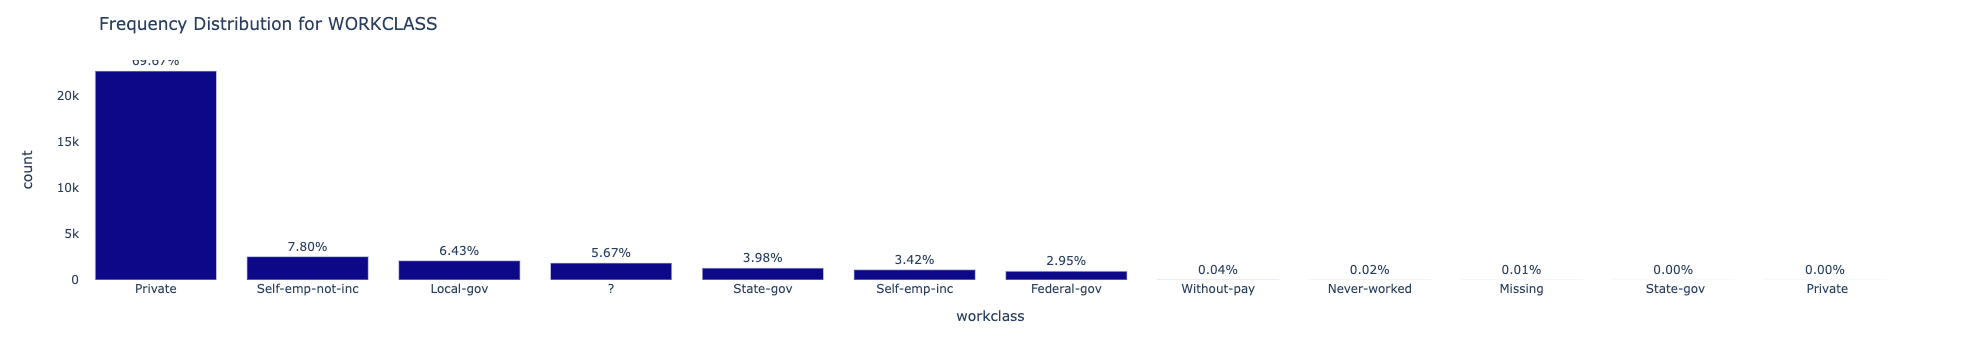

In [19]:
fig_frequency.show()

In [20]:
plotly.offline.plot(fig_frequency, auto_open=False, validate=False, filename="bar_graph.html")

'bar_graph.html'

## Plot Outlier
- API specification of function **plot_outlier** can be found <a href="https://docs.anovos.ai/api/data_report/report_preprocessing.html">here</a>

In [21]:
from anovos.data_report.report_preprocessing import plot_outlier

In [22]:
# Example - plot outlier for one column: education-num
fig_outlier=plot_outlier(spark, df, "education-num", split_var=None, sample_size=500000)

In [23]:
fig_outlier.write_json(ends_with(master_path) + "outlier_" + "education-num")

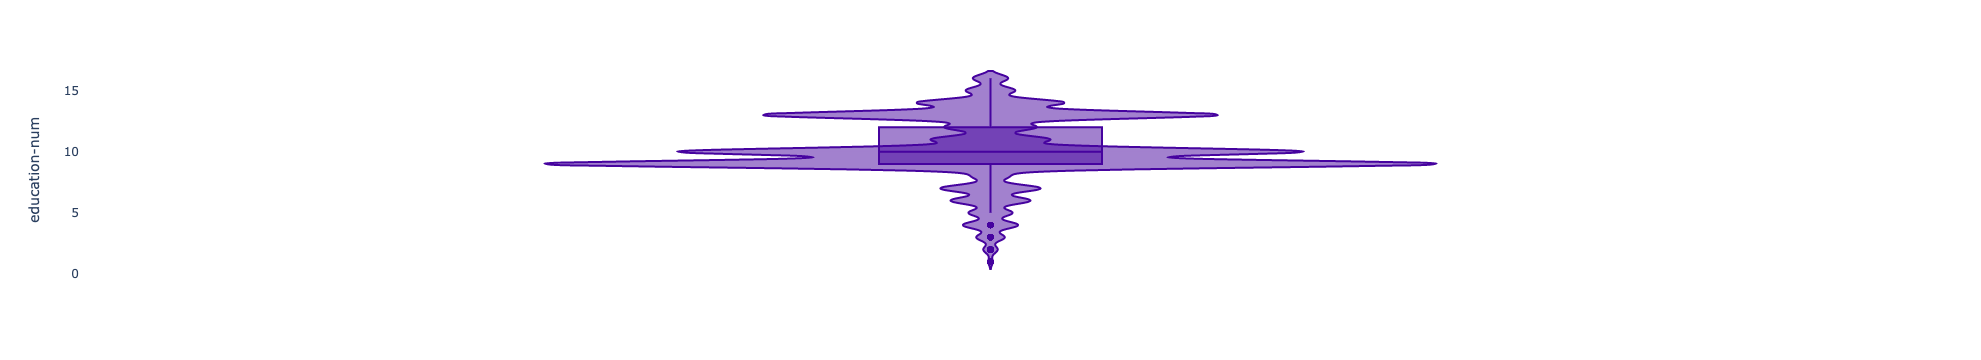

In [24]:
fig_outlier.show()

In [25]:
plotly.offline.plot(fig_outlier, auto_open=False, validate=False, filename="outlier.html")

'outlier.html'

## Plot EventRate
- API specification of function **plot_eventRate** can be found <a href="https://docs.anovos.ai/api/data_report/report_preprocessing.html">here</a>

In [26]:
from anovos.data_report.report_preprocessing import plot_eventRate

In [29]:
# Example - plot frequency for one column: workclass
cutoffs_path = interm_path+"/drift_statistics/attribute_binning"
fig_eventrate=plot_eventRate(spark, df, "workclass", "income", ">50K",cutoffs_path)

2022-12-01 02:41:17.398 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'
2022-12-01 02:41:17.446 | ERROR    | anovos.data_report.report_preprocessing:edit_binRange:149 - processing failed during edit_binRange, error 'NoneType' object has no attribute 'split'


In [30]:
fig_eventrate.write_json(ends_with(master_path) + "eventRist_" + "workclass")

In [31]:
fig_eventrate.show()

In [32]:
plotly.offline.plot(fig_eventrate, auto_open=False, validate=False, filename="feat_analysis_label.html")

'feat_analysis_label.html'

## Plot Comparative Drift
- API specification of function **plot_comparative_drift** can be found <a href="https://docs.anovos.ai/api/data_report/report_preprocessing.html">here</a>

In [33]:
from anovos.data_report.report_preprocessing import plot_comparative_drift

In [34]:
frequency_path = interm_path + "/drift_statistics/frequency_counts/" + "relationship"
idf_source = spark.read.csv(frequency_path, header=True, inferSchema=True)
cutoffs_path = master_path + "/drift_statistics/attribute_binning"

In [35]:
# Example - plot comparative drift for a column: relationship
fig_drift = plot_comparative_drift(spark, df, idf_source, "relationship", cutoffs_path)

In [36]:
fig_drift.write_json(ends_with(master_path) + "drift_" + "relationship")

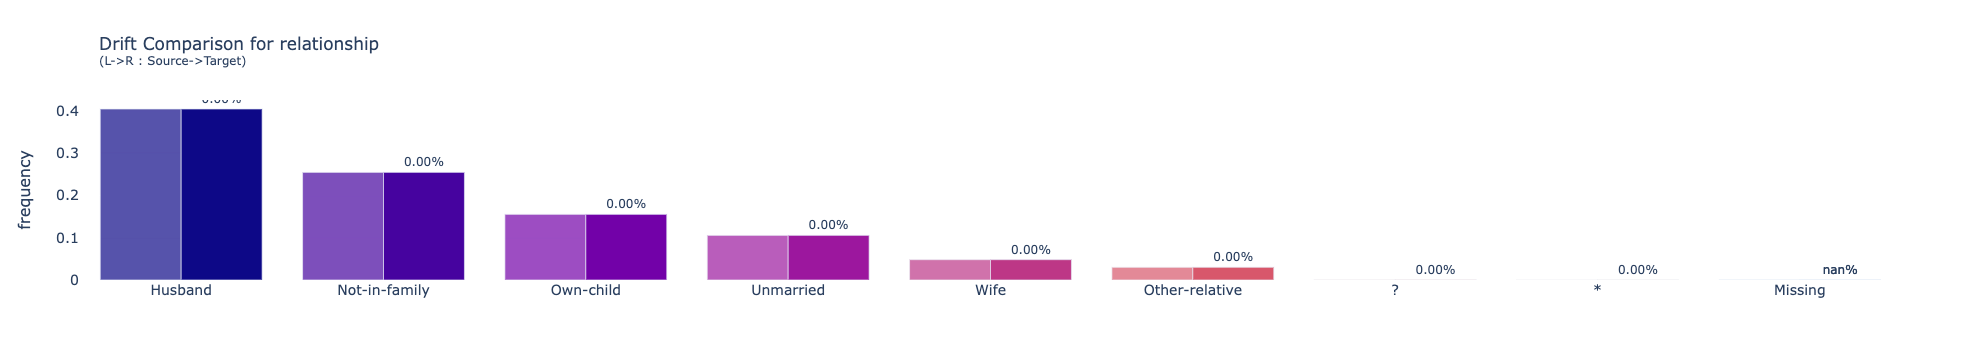

In [37]:
fig_drift.show()

In [38]:
plotly.offline.plot(fig_drift, auto_open=False, validate=False, filename="comp_drift.html")

'comp_drift.html'

# Report Generation

In [39]:
import os
import pandas as pd
import datapane as dp
from anovos.data_report.report_generation import chart_gen_list, drift_stability_ind

default_template = dp.HTML('<html><img src="https://mobilewalla-anovos.s3.amazonaws.com/anovos.png" style="height:100px;display:flex;margin:auto;float:right"></img></html>'),dp.Text("# ML-Anovos Report")

## Generate ANOVOS Report
- API specification of function **anovos_report** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>
- Function charts_to_objects calls all the other report-generating functions (more examples below) in report_generation module.
- Please delete all \*.html file in master_path before running anovos_report if you have run any other function in this section before.
- Please run the command calling charts_to_objects below to make sure other cells in this section run smoothly.

In [40]:
from anovos.data_report.report_generation import anovos_report

In [41]:
# An html file will open automatically once it runs successfully.
anovos_report(master_path, id_col, label_col, corr_threshold, iv_threshold, drift_threshold_model, 
              dataDict_path, metricDict_path, run_type, final_report_path, auth_key=auth_key)

2022-12-01 02:41:34.209 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:635 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:34.210 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:648 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:34.210 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:661 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:34.211 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:674 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:34.214 | ERROR    | anovos.data

App saved to ./../output/income_dataset/data_report//ml_anovos_report.html

Report generated successfully at the specified location


**Because some variables are defined locally in anovos_report, we will copy some code from anovos_report and run it below. In this way, those local variables are defined properly in the current environment.**

In [42]:
global global_summary_df
global numcols_name
global catcols_name
global rows_count
global columns_count
global numcols_count
global catcols_count
global blank_chart
global df_si_
global df_si
global unstable_attr
global total_unstable_attr
global drift_df
global metric_drift
global drift_df
global len_feats
global drift_df_stats
global drifted_feats
global df_stability
global n_df_stability
global stability_interpretation_table
global plot_index_stability

SG_tabs = [
    "measures_of_counts",
    "measures_of_centralTendency",
    "measures_of_cardinality",
    "measures_of_percentiles",
    "measures_of_dispersion",
    "measures_of_shape",
    "global_summary",
]
QC_tabs = [
    "nullColumns_detection",
    "IDness_detection",
    "biasedness_detection",
    "invalidEntries_detection",
    "duplicate_detection",
    "nullRows_detection",
    "outlier_detection",
]
AE_tabs = [
    "correlation_matrix",
    "IV_calculation",
    "IG_calculation",
    "variable_clustering",
]
drift_tab = ["drift_statistics"]
stability_tab = ["stability_index", "stabilityIndex_metrics"]
avl_SG, avl_QC, avl_AE = [], [], []

stability_interpretation_table = pd.DataFrame(
    [
        ["0-1", "Very Unstable"],
        ["1-2", "Unstable"],
        ["2-3", "Marginally Stable"],
        ["3-3.5", "Stable"],
        ["3.5-4", "Very Stable"],
    ],
    columns=["StabilityIndex", "StabilityOrder"],
)
plot_index_stability = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=list(stability_interpretation_table.columns),
                fill_color=px.colors.sequential.Greys[2],
                align="center",
                font=dict(size=12),
            ),
            cells=dict(
                values=[
                    stability_interpretation_table.StabilityIndex,
                    stability_interpretation_table.StabilityOrder,
                ],
                line_color=px.colors.sequential.Greys[2],
                fill_color="white",
                align="center",
                height=25,
            ),
            columnwidth=[2, 10],
        )
    ]
)

plot_index_stability.update_layout(margin=dict(l=20, r=700, t=20, b=20))

blank_chart = go.Figure()
blank_chart.update_layout(autosize=False, width=10, height=10)
blank_chart.layout.plot_bgcolor = global_plot_bg_color
blank_chart.layout.paper_bgcolor = global_paper_bg_color
blank_chart.update_xaxes(visible=False)
blank_chart.update_yaxes(visible=False)

global_summary_df = pd.read_csv(ends_with(master_path) + "global_summary.csv")
rows_count = int(
    global_summary_df[global_summary_df.metric.values == "rows_count"].value.values[
        0
    ]
)
catcols_count = int(
    global_summary_df[
        global_summary_df.metric.values == "catcols_count"
    ].value.values[0]
)
numcols_count = int(
    global_summary_df[
        global_summary_df.metric.values == "numcols_count"
    ].value.values[0]
)
columns_count = int(
    global_summary_df[
        global_summary_df.metric.values == "columns_count"
    ].value.values[0]
)
if catcols_count > 0:
    catcols_name = ",".join(
        list(
            global_summary_df[
                global_summary_df.metric.values == "catcols_name"
            ].value.values
        )
    )
else:
    catcols_name = ""
if numcols_count > 0:
    numcols_name = ",".join(
        list(
            global_summary_df[
                global_summary_df.metric.values == "numcols_name"
            ].value.values
        )
    )
else:
    numcols_name = ""
all_files = os.listdir(master_path)
eventDist_charts = [x for x in all_files if "eventDist" in x]
stats_files = [x for x in all_files if ".csv" in x]
freq_charts = [x for x in all_files if "freqDist" in x]
outlier_charts = [x for x in all_files if "outlier" in x]
drift_charts = [x for x in all_files if "drift" in x and ".csv" not in x]
all_charts_num_1_ = chart_gen_list(
    master_path, chart_type=freq_charts, type_col="numerical"
)
all_charts_num_2_ = chart_gen_list(
    master_path, chart_type=eventDist_charts, type_col="numerical"
)
all_charts_num_3_ = chart_gen_list(
    master_path, chart_type=outlier_charts, type_col="numerical"
)
all_charts_cat_1_ = chart_gen_list(
    master_path, chart_type=freq_charts, type_col="categorical"
)
all_charts_cat_2_ = chart_gen_list(
    master_path, chart_type=eventDist_charts, type_col="categorical"
)
all_drift_charts_ = chart_gen_list(master_path, chart_type=drift_charts)
for x in [
    all_charts_num_1_,
    all_charts_num_2_,
    all_charts_num_3_,
    all_charts_cat_1_,
    all_charts_cat_2_,
    all_drift_charts_,
]:
    if len(x) == 1:
        x.append(dp.Plot(blank_chart, label=" "))
    else:
        x
mapping_tab_list = []
for i in stats_files:
    if i.split(".csv")[0] in SG_tabs:
        mapping_tab_list.append([i.split(".csv")[0], "Descriptive Statistics"])
    elif i.split(".csv")[0] in QC_tabs:
        mapping_tab_list.append([i.split(".csv")[0], "Quality Check"])
    elif i.split(".csv")[0] in AE_tabs:
        mapping_tab_list.append([i.split(".csv")[0], "Attribute Associations"])
    elif i.split(".csv")[0] in drift_tab or i.split(".csv")[0] in stability_tab:
        mapping_tab_list.append([i.split(".csv")[0], "Data Drift & Data Stability"])
    else:
        mapping_tab_list.append([i.split(".csv")[0], "null"])
xx = pd.DataFrame(mapping_tab_list, columns=["file_name", "tab_name"])
xx_avl = list(set(xx.file_name.values))
for i in SG_tabs:
    if i in xx_avl:
        avl_SG.append(i)
for j in QC_tabs:
    if j in xx_avl:
        avl_QC.append(j)
for k in AE_tabs:
    if k in xx_avl:
        avl_AE.append(k)
missing_SG = list(set(SG_tabs) - set(avl_SG))
missing_QC = list(set(QC_tabs) - set(avl_QC))
missing_AE = list(set(AE_tabs) - set(avl_AE))
missing_drift = list(
    set(drift_tab)
    - set(xx[xx.tab_name.values == "Data Drift & Data Stability"].file_name.values)
)
missing_stability = list(
    set(stability_tab)
    - set(xx[xx.tab_name.values == "Data Drift & Data Stability"].file_name.values)
)
ds_ind = drift_stability_ind(
    missing_drift, drift_tab, missing_stability, stability_tab
)

## Generate Executive Summary Report
- API specification of function **executive_summary_gen** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [43]:
from anovos.data_report.report_generation import executive_summary_gen

In [44]:
# An html file will open automatically once it runs successfully.
executive_summary_gen(master_path,label_col,ds_ind,id_col,iv_threshold,corr_threshold,print_report=True)

2022-12-01 02:41:36.011 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:635 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:36.012 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:648 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:36.012 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:661 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:36.013 | ERROR    | anovos.data_report.report_generation:executive_summary_gen:674 - processing failed, error [Errno 2] No such file or directory: '../output/income_dataset/data_report/report_stats/measures_of_shape.csv'
2022-12-01 02:41:36.016 | ERROR    | anovos.data

App saved to ./../output/income_dataset/data_report/report_stats/executive_summary.html

## Generate Wiki Report
- API specification of function **wiki_generator** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [45]:
from anovos.data_report.report_generation import wiki_generator

In [46]:
# An html file will open automatically once it runs successfully.
wiki_generator(master_path,dataDict_path=dataDict_path,metricDict_path=metricDict_path,print_report=True)

App saved to ./../output/income_dataset/data_report/report_stats/wiki_generator.html

## Generate Descriptive Statistics Report
- API specification of function **descriptive_statistics** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [47]:
from anovos.data_report.report_generation import descriptive_statistics

In [48]:
# An html file will open automatically once it runs successfully.
descriptive_statistics(master_path,SG_tabs,avl_SG,missing_SG,all_charts_num_1_,all_charts_cat_1_,print_report=True)

App saved to ./../output/income_dataset/data_report/report_stats/descriptive_statistics.html

## Generate Quality Check Report
- API specification of function **quality_check** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [49]:
from anovos.data_report.report_generation import quality_check

In [50]:
# An html file will open automatically once it runs successfully.
quality_check(master_path,QC_tabs,avl_QC,missing_QC,all_charts_num_3_,print_report=True)

App saved to ./../output/income_dataset/data_report/report_stats/quality_check.html

## Generate Attribute Associations Report
- API specification of function **attribute_associations** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [51]:
from anovos.data_report.report_generation import attribute_associations

In [52]:
# An html file will open automatically once it runs successfully.
attribute_associations(master_path,AE_tabs,avl_AE,missing_AE,label_col,all_charts_num_2_,all_charts_cat_2_,print_report=True)

App saved to ./../output/income_dataset/data_report/report_stats/attribute_associations.html

## Generate Drift and Stability Report
- API specification of function **data_drift_stability** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [53]:
from anovos.data_report.report_generation import data_drift_stability

In [54]:
# An html file will open automatically once it runs successfully.
data_drift_stability(master_path,ds_ind,id_col,drift_threshold_model,all_drift_charts_,print_report=True)

App saved to ./../output/income_dataset/data_report/report_stats/data_drift_stability.html

## Generate Time Series Visualization Report
- API specification of function **ts_viz_generate** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [55]:
from anovos.data_report.report_generation import ts_viz_generate

In [56]:
# An html file will open automatically once it runs successfully.
ts_viz_generate(ends_with(master_path), id_col, 'daily')

App saved to ./../output/income_dataset/data_report/report_stats/time_series_analyzer.html

'null_report'

###  Useful Functions for Time Series Visualization
#### Plot Seasonal Decompose
- API specification of function **plotSeasonalDecompose** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [57]:
from anovos.data_report.report_generation import plotSeasonalDecompose

In [58]:
fig_seasonal = plotSeasonalDecompose(ends_with(master_path), 'dt_1', 'hours-per-week', metric_col="mean")
fig_seasonal.show()

#### Generate Time Series Plots
- API specification of function **gen_time_series_plots** can be found <a href="https://docs.anovos.ai/api/data_report/report_generation.html">here</a>

In [59]:
from anovos.data_report.report_generation import gen_time_series_plots

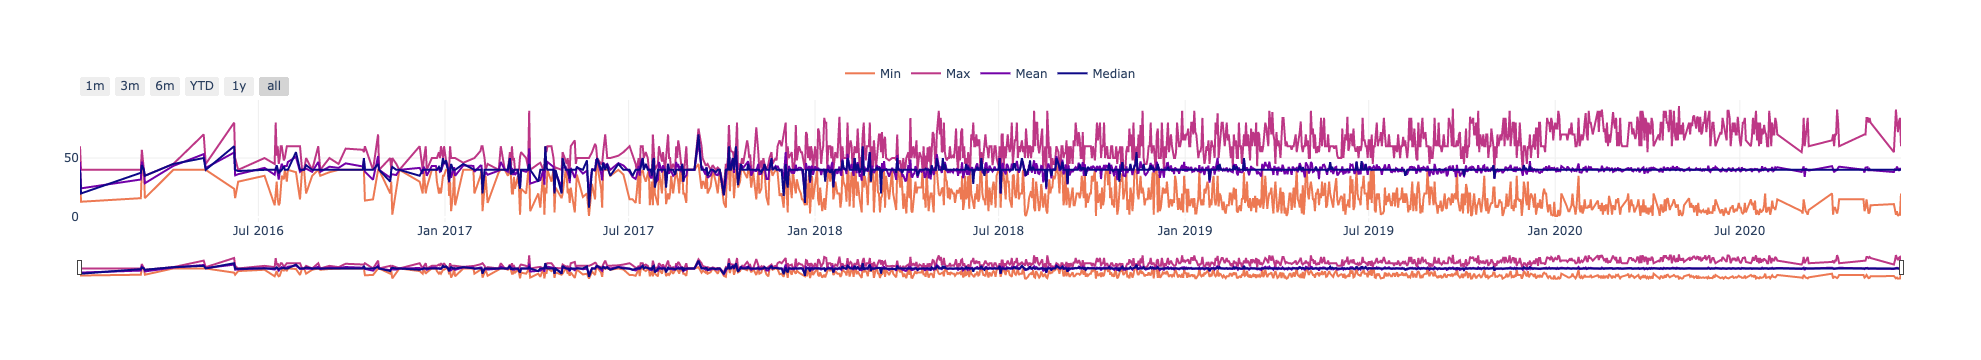

In [60]:
fig_ts = gen_time_series_plots(ends_with(master_path), 'dt_1', 'hours-per-week', time_cat="daily")
fig_ts.show()

# Generate Geospatial Analysis Report

In [61]:
from anovos.data_report.report_generation import loc_report_gen

In [62]:
# An html file will open automatically once it runs successfully.
loc_report_gen(lat_cols, long_cols, gh_cols, master_path, max_records, top_geo_records, True)

App saved to ./../output/income_dataset/data_report/report_stats/geospatial_analyzer.html